In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy
import cv2

In [2]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [3]:
# Gloabl parameter setup
# path for CBEDs, start with unconvoluted ones, tile, then do convolution. Tiling artifact can be avoided in this way.
path = '/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/scratch/Si_disl/'
slc = 5
rep_x = 1
rep_y = 1
base_name = 'Si_disl_slice'+str(slc)
base_ext = '_FPavg.npy'
array_size = (114,114)  # real space array size for single unit cell
source_size = 110

In [43]:
imsize = (np.load(path+base_name+'_X0_Y0'+base_ext)).shape
out_sz = array_size + imsize
output = np.zeros(out_sz,dtype=np.float32)
for x in range(array_size[0]):
        for y in range(array_size[1]):
            output[x,y,:,:] = np.load(path+base_name+'_X'+str(x)+'_Y'+str(y)+base_ext)
output = np.squeeze(output)
output = output / 17  # for 17 phonons used

# tile the unconvoluted array
# output_crop = output[9:31,9:31,:,:]  # crop the original datacube to have one unit cell
output_tile = np.tile(output,(rep_x,rep_y,1,1))

# generate convolution kernel
source_size = 110
px_size = 17.5
sigma = (source_size/px_size)/(2.355)
kernel = gaussKernel(sigma,output_tile.shape[0])
fkernel = np.fft.fft2(kernel)

# Gaussian convolution with FFT
kx,ky = output_tile.shape[2:4]
#initialize result array
result = np.zeros(output_tile.shape,dtype=np.float32)
for k in range(kx):
    for l in range(ky):
        #apply convolution for each pixel in (kx,ky) over the whole set of images in (x,y)
        result[:,:,k,l] = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(output_tile[:,:,k,l]))).real

print(result.shape)

KeyboardInterrupt: 

In [4]:
result = np.load('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/slice'+str(slc)+'_'+str(source_size)+\
       'pmss.npy')

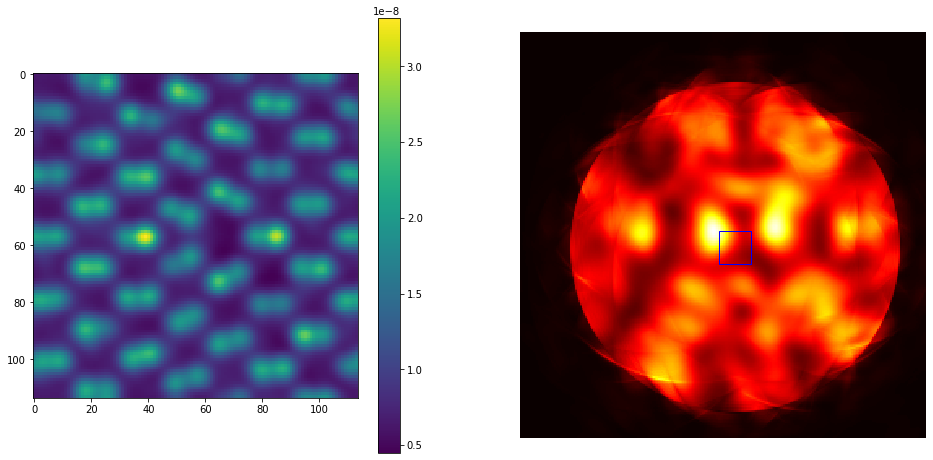

In [7]:
import matplotlib.patches as patches

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(result[:,:,10,10])
plt.colorbar()

ax = plt.subplot(122)
ax.imshow(result[10,10,200:450,200:450],cmap='hot')
ax.axis('off')
rect = patches.Rectangle((122,122),20,20,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect)

In [27]:
np.save('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/slice'+str(slc)+'_'+str(source_size)+\
       'pmss.npy',result)

In [103]:
FPS_list = [1000,2000,4000,6000,8000,10000,20000,40000]
# crop 4D dataset to 128x128 in k-space
datacube_cropped = result[:,:,205:461:2,205:461:2]
datacube_cropped = datacube_cropped / np.sum(datacube_cropped) * np.sum(result[:,:,205:461,205:461])
print(datacube_cropped.shape)

for iFPS in range(len(FPS_list)):
    FPS = FPS_list[iFPS]
    
    # Save truth in unit of electrons, in 3D stack
    datacube_truth = np.zeros((datacube_cropped.shape[0],datacube_cropped.shape[1],datacube_cropped.shape[2]*datacube_cropped.shape[3]))
    for i in range(datacube_cropped.shape[2]):
        for j in range(datacube_cropped.shape[3]):
            datacube_truth[:,:,i*datacube_cropped.shape[3]+j] = datacube_cropped[:,:,i,j]*current/1.6/FPS*10000000
    np.save('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_truth_SiDisl_slc'+str(slc)\
            +'_'+str(FPS)+'FPS.npy',datacube_truth)

    # Add noise after rescale dataset to number of electrons
    datacube_noisy = np.zeros(datacube_truth.shape,dtype=np.uint8)
    for i in range(datacube_truth.shape[2]):
        frame = datacube_truth[:,:,i]
        datacube_noisy[:,:,i] = np.random.poisson(frame).astype('int')

    # save noisy datacube in .mat file
    adict = {}
    adict['datacube'] = datacube_noisy
    sio.savemat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/Simulation_noisy_SiDisl_slc'+str(slc)\
                +'_'+str(FPS)+'FPS.mat', adict)
    

(114, 114, 128, 128)


In [104]:
print(np.sum(datacube_cropped))
print(result.shape)

12594.755
(114, 114, 664, 664)


In [7]:
current = 18.9 # beam current in pA
FPS_list = [1000,2000,4000,6000,8000,10000,20000,40000]

for i in range(len(FPS_list)):
    FPS = FPS_list[i]
    print(FPS)
    # crop 4D dataset to 10x10 in k-space for comparison between NLPCA and tensor SVD
    datacube_cropped = result[:,:,322:342:2,322:342:2]
    datacube_cropped = datacube_cropped / np.sum(datacube_cropped) * np.sum(result[:,:,292:312,292:312])

    # Save truth in unit of electrons, in 3D stack
    datacube_truth = np.zeros((datacube_cropped.shape[0],datacube_cropped.shape[1],datacube_cropped.shape[2]*datacube_cropped.shape[3]))
    for i in range(datacube_cropped.shape[2]):
        for j in range(datacube_cropped.shape[3]):
            datacube_truth[:,:,i*datacube_cropped.shape[3]+j] = datacube_cropped[:,:,i,j]*current/1.6/FPS*10000000
    np.save('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations\
/Simulation_truth_SiDisl_slice_'+str(slc)+'_'+str(FPS)+'FPS_cropped_100layers.npy',datacube_truth)

    # Add noise after rescale dataset to number of electrons
    datacube_noisy = np.zeros(datacube_truth.shape,dtype=np.uint8)
    for i in range(datacube_truth.shape[2]):
        frame = datacube_truth[:,:,i]
        datacube_noisy[:,:,i] = np.random.poisson(frame).astype('int')

    # save noisy datacube in .mat file
    adict = {}
    adict['datacube'] = datacube_noisy
    sio.savemat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations\
/Simulation_noisy_SiDisl_slice_'+str(slc)+'_'+str(FPS)+'FPS_cropped_100layers.mat',adict)

1000
2000
4000
6000
8000
10000
20000
40000


In [85]:
# Prepare cropped dataset based on symmetric points on a circular mask
current = 18.9 # beam current in pA
FPS = 2000     # frame rate
FPS_list = [1000,2000,4000,6000,8000,10000,20000,40000]

# A circular mask with less points can be generated by using a smaller gap between two radii, 100 points in total
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=48) & \
~create_circular_mask(128, 128, center=(64,64), radius=47.52)
nlayers = np.sum(circular_mask)

# Crop and reshape the datacube to get 128x128 points in reciprocal space, then apply the mask
datacube_cropped = result[:,:,205:461:2,205:461:2]
datacube_cropped = datacube_cropped / np.sum(datacube_cropped) * np.sum(result[:,:,205:461,205:461])

for iFPS in range(len(FPS_list)):
    FPS = FPS_list[iFPS]
    print(FPS)

    # Save truth in unit of electrons, in 3D stack
    datacube_truth = np.zeros((datacube_cropped.shape[0],datacube_cropped.shape[1],nlayers))
    count = 0
    for i in range(datacube_cropped.shape[2]):
        for j in range(datacube_cropped.shape[3]):
            if circular_mask[i,j] == 1:
                
                datacube_truth[:,:,count] = datacube_cropped[:,:,i,j]*current/1.6/FPS*10000000
    np.save('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations\
/Simulation_truth_SiDisl_slice_'+str(slc)+'_'+str(FPS)+'FPS_cropped_100layers_2.npy',datacube_truth)

    # Generate datacube with Poisson noise with existing datacube
    datacube_noisy = np.zeros(datacube_truth.shape,dtype=np.uint8)
    for i in range(datacube_truth.shape[2]):
        frame = datacube_truth[:,:,i]
        datacube_noisy[:,:,i] = np.random.poisson(frame).astype('int')

    # save noisy datacube in .mat file
    adict = {}
    adict['datacube'] = datacube_noisy
    sio.savemat('/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations\
/Simulation_noisy_SiDisl_slice_'+str(slc)+'_'+str(FPS)+'FPS_cropped_100layers_2.mat',adict)

1000
2000
4000
6000
8000
10000
20000
40000


In [94]:
datacube_cropped = result[:,:,205:461:2,205:461:2]
datacube_cropped = datacube_cropped / np.sum(datacube_cropped) * np.sum(result[:,:,205:461,205:461])

96
132.36742


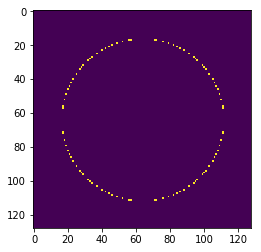

In [101]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=47.7) & \
~create_circular_mask(128, 128, center=(64,64), radius=47.395)
plt.imshow(circular_mask)
print(np.sum(circular_mask))

_, mask_b = np.broadcast_arrays(datacube_cropped,circular_mask[None,None,...])
datacube_masked = datacube_cropped * mask_b

print(np.sum(datacube_masked))

In [38]:
filename = '/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/NewSim_result/SiDisl'
f = h5py.File(filename,'r')
f.keys()
dataset = f['4DSTEM_simulation']
log = dataset['log']

<KeysViewHDF5 []>


In [31]:
# output from new prismatic in hdf5 format
import h5py
slc = 2
filename = '/srv/home/chenyu/TensorDenoise/Simulatons/Si_dislocation_simulations/NewSim_result/SiDisl'
f = h5py.File(filename,'r')
f.keys()
dataset = f['4DSTEM_simulation']
dataset = dataset['data']
dataset = dataset['datacubes']
output = dataset['CBED_array_depth'+ "{:0>4d}".format(slc)]
output = output['datacube']

(161, 161, 664, 664)


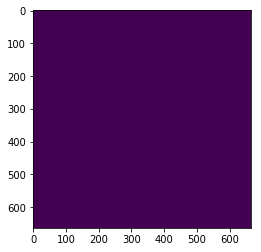

In [32]:
# print(dataset.keys())
print(output.shape)
plt.imshow(output[10,10,:,:])
# print(np.sum(output))

In [16]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask